In [1]:
!nvidia-smi

Sun Aug  3 21:45:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8             17W /   65W |    4676MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

def check_gpu():
    print("="*40)
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_name = torch.cuda.get_device_name(0)
        total_mem = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)
        capability = torch.cuda.get_device_capability(0)
        print("✅ GPU is available and being used.")
        print(f"🖥️  Device     : {gpu_name}")
        print(f"💾 Memory     : {total_mem:.2f} GB")
        print(f"⚙️  Capability : {capability}")
        print(f"📌 Torch Device : {device}")
    else:
        device = torch.device("cpu")
        print("❌ GPU not available. Using CPU instead.")
        print(f"📌 Torch Device : {device}")
    print("="*40)

check_gpu()


✅ GPU is available and being used.
🖥️  Device     : NVIDIA GeForce RTX 3060 Laptop GPU
💾 Memory     : 6.00 GB
⚙️  Capability : (8, 6)
📌 Torch Device : cuda


In [3]:
# Cell 1 — Imports & Config

import os, random, time
from datetime import datetime

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

# Device & seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

# ImageNet normalization
IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]


In [4]:
# Cell 2 — Dataset (OpenCV, one random frame per video)

class VideoFrameDataset(Dataset):
    def __init__(self, root_dir, folders, transform=None):
        """
        root_dir: path containing your two subfolders
        folders: ['DFD_original_sequences','DFD_manipulated_sequences']
        """
        self.samples = []
        for label, f in enumerate(folders):
            p = os.path.join(root_dir, f)
            for fname in os.listdir(p):
                full = os.path.join(p, fname)
                if os.path.isfile(full):
                    self.samples.append((full, label))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise RuntimeError(f"Cannot open {video_path}")
        n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        if n <= 0:
            raise RuntimeError(f"No frames in {video_path}")

        # pick a random frame
        frame_idx = random.randint(0, n - 1)
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ok, frame = cap.read()
        cap.release()
        if not ok:
            raise RuntimeError(f"Failed read frame {frame_idx} from {video_path}")

        # BGR→RGB, PIL, transform
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        if self.transform:
            img = self.transform(img)
        return img, label


In [5]:
# Cell 3 — Transforms & DataLoaders

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

data_root = "../subset"
folders   = ['DFD_original_sequences','DFD_manipulated_sequences']

# build dataset and split
full_ds = VideoFrameDataset(data_root, folders, transform)
n_train = int(0.8 * len(full_ds))
n_val   = len(full_ds) - n_train
train_ds, val_ds = torch.utils.data.random_split(full_ds, [n_train, n_val])

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [6]:
# Cell 4 — ResNet-Swish-BiLSTM Model

class ResNetSwishBiLSTM(nn.Module):
    def __init__(self, num_classes=2, lstm_hidden=256, lstm_layers=1):
        super().__init__()
        # ResNet-50 backbone, drop final FC
        resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # [B,2048,1,1]
        # Swish activation (SiLU)
        self.swish = nn.SiLU()
        # BiLSTM over feature vectors
        self.lstm = nn.LSTM(
            input_size=2048,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            bidirectional=True,
            batch_first=False
        )
        # classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(lstm_hidden * 2, num_classes)
        )

    def forward(self, x):
        # x: [B,3,H,W]
        feat = self.backbone(x)                  # [B,2048,1,1]
        feat = feat.view(feat.size(0), -1)       # [B,2048]
        feat = self.swish(feat)                  # [B,2048]
        # add time dim = 1
        seq = feat.unsqueeze(0)                  # [1,B,2048]
        out, _ = self.lstm(seq)                  # [1,B,hidden*2]
        last = out[-1]                           # [B,hidden*2]
        return self.classifier(last)

# instantiate
model = ResNetSwishBiLSTM(num_classes=2).to(device)


c:\Users\mohit\Desktop\PROJECTS\AI Image Detection\resnet-50\resnet_env_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mohit\Desktop\PROJECTS\AI Image Detection\resnet-50\resnet_env_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Cell 5 — Trainer with detailed tqdm & metrics

class Trainer:
    def __init__(self, model, train_loader, val_loader, device,
                 lr=1e-4, ckpt_dir="Resnet-swish_BiLSTM_model._checkpoints"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader   = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.ckpt_dir = ckpt_dir
        os.makedirs(ckpt_dir, exist_ok=True)

        # history dict
        self.history = {k: [] for k in [
            "train_loss","train_acc",
            "val_loss","val_acc","val_prec","val_rec","val_f1",
            "val_roc_auc","val_pr_auc"
        ]}

    def train_epoch(self, epoch):
        self.model.train()
        running_loss, preds, trues = 0.0, [], []
        start = time.time()
        loop = tqdm(
            self.train_loader,
            desc=f"Epoch {epoch} ▶ Train",
            unit="batch",
            dynamic_ncols=True,
            leave=True
        )
        for imgs, labels in loop:
            imgs, labels = imgs.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
            out = self.model(imgs)
            loss = self.criterion(out, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds.extend(out.argmax(1).cpu().tolist())
            trues.extend(labels.cpu().tolist())

            loop.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc":  f"{100*accuracy_score(trues, preds):.2f}%",
                "lr":   f"{self.optimizer.param_groups[0]['lr']:.1e}"
            })

        elapsed = time.time() - start
        epoch_loss = running_loss / len(trues)
        epoch_acc  = accuracy_score(trues, preds)

        self.history["train_loss"].append(epoch_loss)
        self.history["train_acc"].append(epoch_acc)
        print(f"→ Train: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}, time={elapsed:.1f}s")

    def validate_epoch(self, epoch):
        self.model.eval()
        running_loss, probs, trues = 0.0, [], []
        start = time.time()
        loop = tqdm(
            self.val_loader,
            desc=f"Epoch {epoch} ▶ Valid",
            unit="batch",
            dynamic_ncols=True,
            leave=True
        )
        with torch.no_grad():
            for imgs, labels in loop:
                imgs, labels = imgs.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
                out = self.model(imgs)
                loss = self.criterion(out, labels)

                running_loss += loss.item() * imgs.size(0)
                p = torch.softmax(out, dim=1)[:,1]  # P(fake)
                probs.extend(p.cpu().tolist())
                trues.extend(labels.cpu().tolist())

                loop.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc":  f"{100*accuracy_score(trues, [x>0.5 for x in probs]):.2f}%"
                })

        elapsed = time.time() - start
        val_loss = running_loss / len(trues)
        val_acc  = accuracy_score(trues, [x>0.5 for x in probs])
        prec, rec, f1, _ = precision_recall_fscore_support(
            trues, [x>0.5 for x in probs], average='binary', zero_division=0)
        fpr, tpr, _ = roc_curve(trues, probs)
        roc_auc = auc(fpr, tpr)
        pr, rc, _ = precision_recall_curve(trues, probs)
        pr_auc  = average_precision_score(trues, probs)

        # log
        self.history["val_loss"].append(val_loss)
        self.history["val_acc"].append(val_acc)
        self.history["val_prec"].append(prec)
        self.history["val_rec"].append(rec)
        self.history["val_f1"].append(f1)
        self.history["val_roc_auc"].append(roc_auc)
        self.history["val_pr_auc"].append(pr_auc)

        print(f"→ Valid: loss={val_loss:.4f}, acc={val_acc:.4f}, time={elapsed:.1f}s")
        return val_acc, (fpr, tpr, pr, rc, trues, probs)

    def save_checkpoint(self, epoch, best=False):
        fn = f"epoch_{epoch}.pth" if not best else "best_model.pth"
        path = os.path.join(self.ckpt_dir, fn)
        torch.save({
            "epoch": epoch,
            "model_state": self.model.state_dict(),
            "optim_state": self.optimizer.state_dict()
        }, path)
        print(f"[Checkpoint] Saved {fn}")

    def fit(self, epochs=20):
        best_acc = 0.0
        for ep in range(1, epochs+1):
            print(f"\n=== Epoch {ep}/{epochs} ===")
            self.train_epoch(ep)
            val_acc, roc_pr = self.validate_epoch(ep)
            self.save_checkpoint(ep)
            if val_acc > best_acc:
                best_acc = val_acc
                self.save_checkpoint(ep, best=True)
        print(f"\nTraining complete. Best val acc: {best_acc:.4f}")
        return roc_pr


In [8]:
# Cell 6 — Run training (20 epochs)

trainer = Trainer(model, train_loader, val_loader, device)

In [9]:
roc_pr_data = trainer.fit(epochs=20)



=== Epoch 1/20 ===


Epoch 1 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.7085, acc=0.4437, time=41.4s


Epoch 1 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.6776, acc=0.5500, time=9.4s
[Checkpoint] Saved epoch_1.pth
[Checkpoint] Saved best_model.pth

=== Epoch 2/20 ===


Epoch 2 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.6186, acc=0.7250, time=41.7s


Epoch 2 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.7083, acc=0.6000, time=8.9s
[Checkpoint] Saved epoch_2.pth
[Checkpoint] Saved best_model.pth

=== Epoch 3/20 ===


Epoch 3 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.5399, acc=0.7750, time=41.2s


Epoch 3 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.7919, acc=0.6250, time=10.0s
[Checkpoint] Saved epoch_3.pth
[Checkpoint] Saved best_model.pth

=== Epoch 4/20 ===


Epoch 4 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.4305, acc=0.8125, time=42.9s


Epoch 4 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.8740, acc=0.5500, time=10.6s
[Checkpoint] Saved epoch_4.pth

=== Epoch 5/20 ===


Epoch 5 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3580, acc=0.8438, time=41.9s


Epoch 5 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0269, acc=0.6250, time=10.1s
[Checkpoint] Saved epoch_5.pth

=== Epoch 6/20 ===


Epoch 6 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3823, acc=0.8187, time=43.0s


Epoch 6 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.1062, acc=0.6250, time=10.4s
[Checkpoint] Saved epoch_6.pth

=== Epoch 7/20 ===


Epoch 7 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3466, acc=0.8438, time=43.9s


Epoch 7 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0623, acc=0.5500, time=10.1s
[Checkpoint] Saved epoch_7.pth

=== Epoch 8/20 ===


Epoch 8 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3095, acc=0.8812, time=42.6s


Epoch 8 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.8816, acc=0.6250, time=10.0s
[Checkpoint] Saved epoch_8.pth

=== Epoch 9/20 ===


Epoch 9 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2319, acc=0.9000, time=43.1s


Epoch 9 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.1594, acc=0.5250, time=10.0s
[Checkpoint] Saved epoch_9.pth

=== Epoch 10/20 ===


Epoch 10 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2798, acc=0.8688, time=42.3s


Epoch 10 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0102, acc=0.6500, time=10.2s
[Checkpoint] Saved epoch_10.pth
[Checkpoint] Saved best_model.pth

=== Epoch 11/20 ===


Epoch 11 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3152, acc=0.8688, time=43.7s


Epoch 11 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0184, acc=0.6500, time=10.5s
[Checkpoint] Saved epoch_11.pth

=== Epoch 12/20 ===


Epoch 12 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2409, acc=0.8750, time=43.9s


Epoch 12 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.3261, acc=0.6500, time=10.3s
[Checkpoint] Saved epoch_12.pth

=== Epoch 13/20 ===


Epoch 13 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3023, acc=0.8562, time=43.0s


Epoch 13 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.3495, acc=0.5750, time=10.3s
[Checkpoint] Saved epoch_13.pth

=== Epoch 14/20 ===


Epoch 14 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2329, acc=0.8875, time=42.2s


Epoch 14 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.2793, acc=0.5500, time=10.4s
[Checkpoint] Saved epoch_14.pth

=== Epoch 15/20 ===


Epoch 15 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2540, acc=0.9313, time=43.5s


Epoch 15 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.3971, acc=0.6000, time=9.7s
[Checkpoint] Saved epoch_15.pth

=== Epoch 16/20 ===


Epoch 16 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.1322, acc=0.9437, time=42.9s


Epoch 16 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.2279, acc=0.6000, time=9.9s
[Checkpoint] Saved epoch_16.pth

=== Epoch 17/20 ===


Epoch 17 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.1852, acc=0.9187, time=44.7s


Epoch 17 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.3704, acc=0.6000, time=10.6s
[Checkpoint] Saved epoch_17.pth

=== Epoch 18/20 ===


Epoch 18 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.1593, acc=0.9125, time=43.0s


Epoch 18 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.2583, acc=0.5750, time=10.1s
[Checkpoint] Saved epoch_18.pth

=== Epoch 19/20 ===


Epoch 19 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.1592, acc=0.9375, time=42.5s


Epoch 19 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.5178, acc=0.5750, time=10.2s
[Checkpoint] Saved epoch_19.pth

=== Epoch 20/20 ===


Epoch 20 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2282, acc=0.9187, time=41.7s


Epoch 20 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.7433, acc=0.6000, time=10.2s
[Checkpoint] Saved epoch_20.pth

Training complete. Best val acc: 0.6500


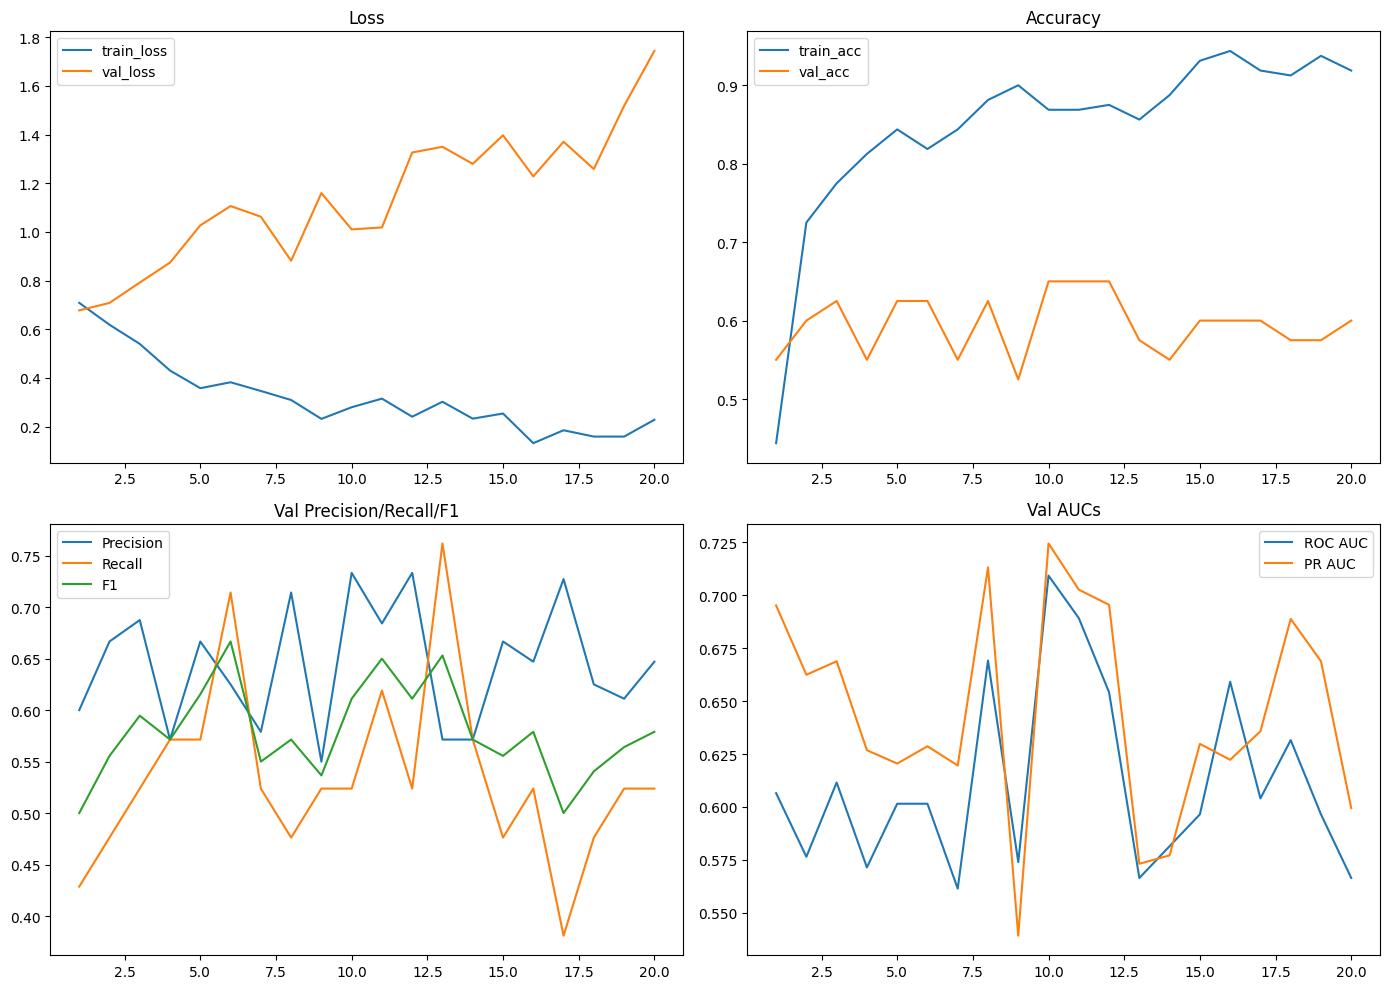

In [10]:
# Cell 7 — Plot Loss, Accuracy, Precision, Recall & F1 over epochs

h = trainer.history
epo = list(range(1, len(h["train_loss"])+1))

plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(epo, h["train_loss"], label="train_loss")
plt.plot(epo, h["val_loss"] , label="val_loss")
plt.title("Loss"); plt.legend()

plt.subplot(2,2,2)
plt.plot(epo, h["train_acc"], label="train_acc")
plt.plot(epo, h["val_acc"] , label="val_acc")
plt.title("Accuracy"); plt.legend()

plt.subplot(2,2,3)
plt.plot(epo, h["val_prec"], label="Precision")
plt.plot(epo, h["val_rec"] , label="Recall")
plt.plot(epo, h["val_f1"]  , label="F1")
plt.title("Val Precision/Recall/F1"); plt.legend()

plt.subplot(2,2,4)
plt.plot(epo, h["val_roc_auc"], label="ROC AUC")
plt.plot(epo, h["val_pr_auc"] , label="PR AUC")
plt.title("Val AUCs"); plt.legend()

plt.tight_layout()
plt.show()


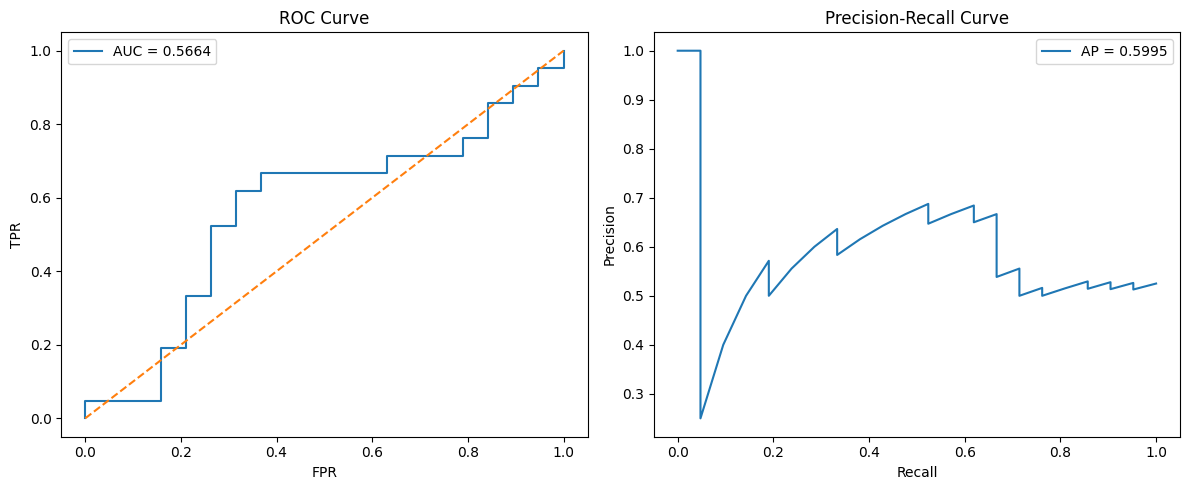

In [11]:
# Cell 8 — ROC & PR curves for final epoch

fpr, tpr, pr, rc, y_true, y_prob = roc_pr_data

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {h['val_roc_auc'][-1]:.4f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rc, pr, label=f"AP = {h['val_pr_auc'][-1]:.4f}")
plt.title("Precision-Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()

plt.tight_layout()
plt.show()


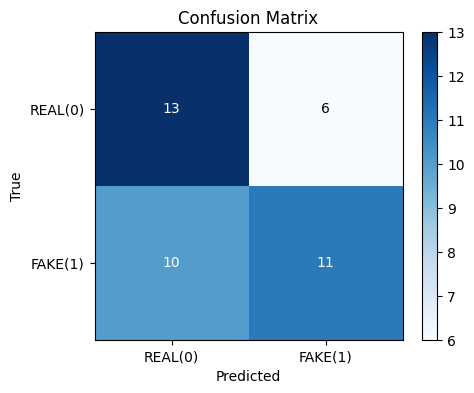


Classification Report:
              precision    recall  f1-score   support

     REAL(0)       0.57      0.68      0.62        19
     FAKE(1)       0.65      0.52      0.58        21

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40



In [12]:
# Cell 9 — Confusion Matrix & Classification Report

y_pred = [p>0.5 for p in y_prob]
cm = confusion_matrix(y_true, y_pred)
labels = ['REAL(0)','FAKE(1)']

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]),
                 ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.xticks([0,1], labels); plt.yticks([0,1], labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


In [13]:
# Cell 10 — Save all results to Excel

import pandas as pd
from sklearn.metrics import classification_report

# 1) Epoch‐level metrics
epoch_df = pd.DataFrame(trainer.history)

# 2) ROC curve data
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr
})

# 3) Precision‐Recall curve data
pr_df = pd.DataFrame({
    'recall': rc,
    'precision': pr
})

# 4) Confusion matrix
cm_df = pd.DataFrame(
    cm,
    index=labels,
    columns=labels
)

# 5) Classification report
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=labels,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

# 6) Raw predictions & probabilities
preds_df = pd.DataFrame({
    'y_true':   y_true,
    'y_prob':  y_prob
})

# === Write to Excel with multiple sheets ===
out_file = "ResNetSwishBiLSTM_results.xlsx"
with pd.ExcelWriter(out_file, engine='openpyxl') as writer:
    epoch_df.to_excel(writer, sheet_name='epoch_metrics', index=False)
    roc_df.to_excel(writer, sheet_name='roc_curve',     index=False)
    pr_df.to_excel(writer, sheet_name='pr_curve',      index=False)
    cm_df.to_excel(writer, sheet_name='confusion_matrix')
    report_df.to_excel(writer, sheet_name='class_report')
    preds_df.to_excel(writer, sheet_name='predictions',  index=False)

print(f"✅ All results saved to {out_file}")


✅ All results saved to ResNetSwishBiLSTM_results.xlsx
